In [1]:
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

In [2]:
# !wget https://pjreddie.com/media/files/yolov3.weights

In [3]:
# !wget https://raw.githubusercontent.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch/master/data/coco.names

In [4]:
!cat "yolov3.cfg"

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
width=320
height=320
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutiona

In [5]:
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from coco import load_classes
from visualize import (
    uniform_color_palette, read_img, resize_aspect,
    inv_aspect_transform_results, aspect_transform,
    clamp_results, img_to_tensor,
    draw_predictions, draw_palette
)
from modules import Darknet
from utils import write_results

In [6]:
classes = load_classes('coco.names')
num_classes = len(classes)
print('classes:', num_classes)

classes: 80


In [7]:
palette = uniform_color_palette(num_classes)

p_img = draw_palette(palette)
plt.imshow(p_img)
plt.axis('off')
plt.show()

pos = np.arange(0, palette.shape[1], 1)
np.random.shuffle(pos)
palette = palette[:, pos]

In [8]:
CUDA = torch.cuda.is_available()
CUDA = False
print(CUDA)

False


In [9]:
model = Darknet('yolov3.cfg')
model.load_weights('yolov3.weights')
if CUDA:
    model.cuda()
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

In [10]:
width = model.net_info['width']
height = model.net_info['height']

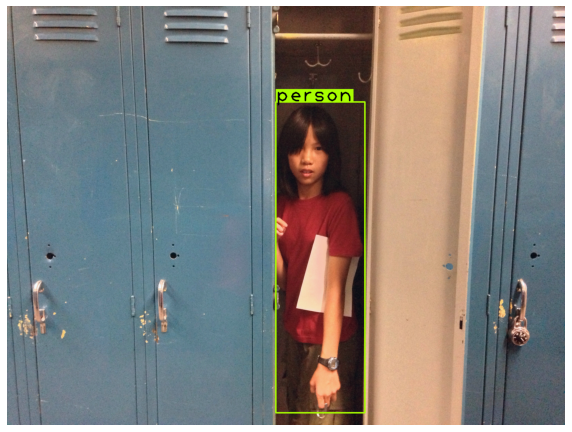

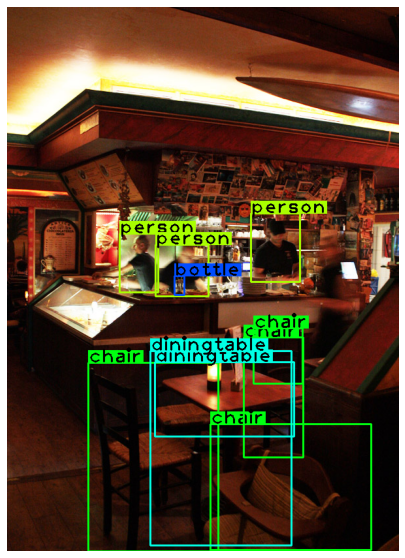

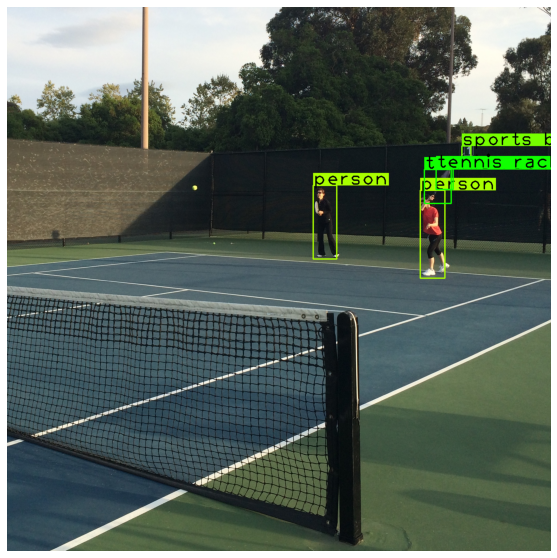

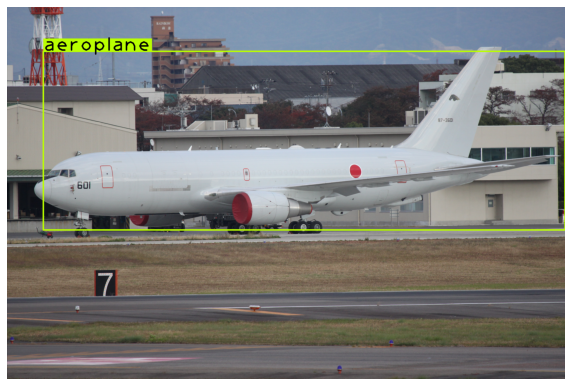

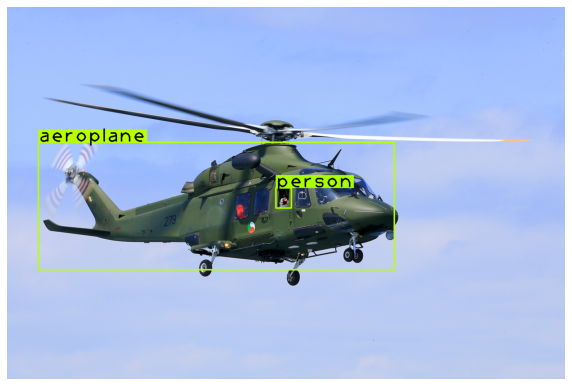

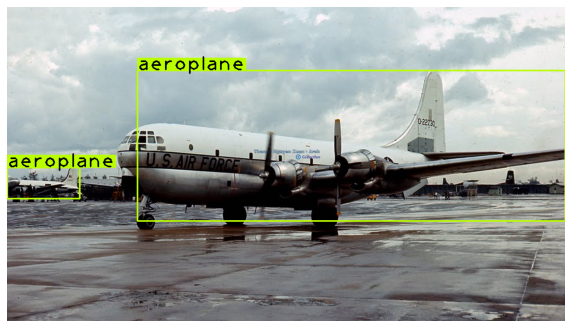

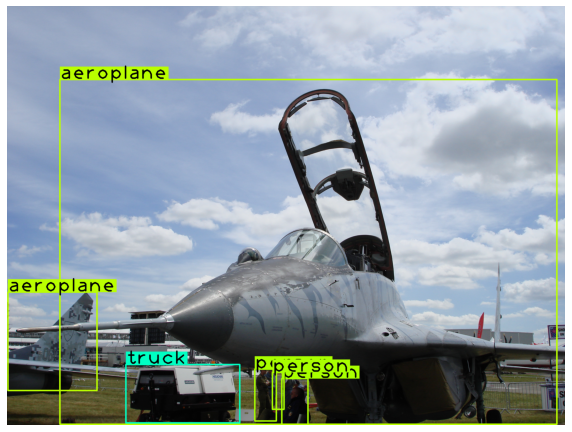

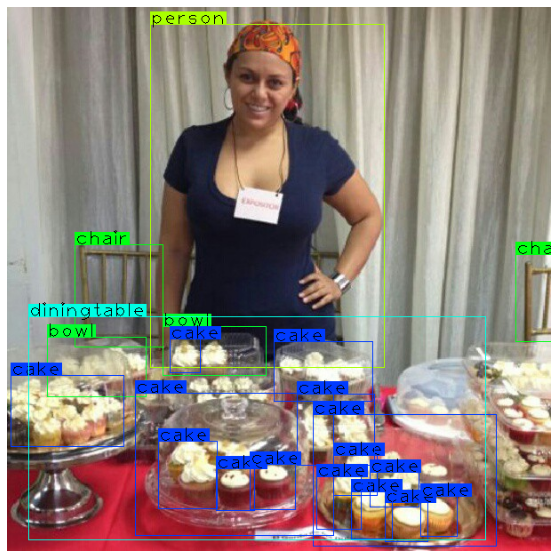

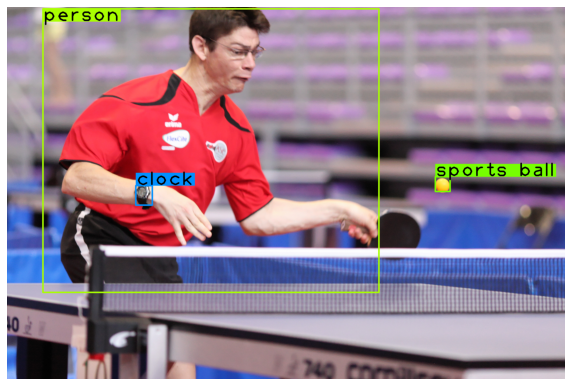

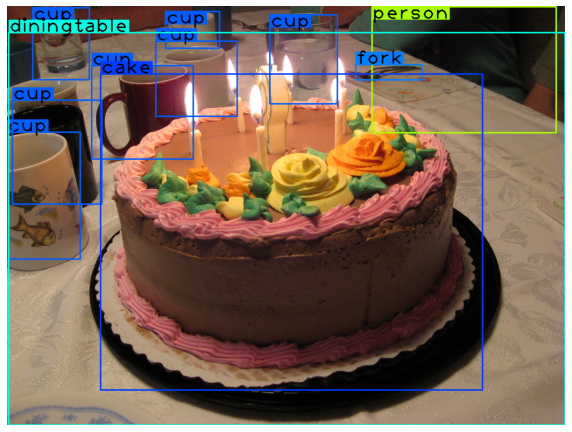

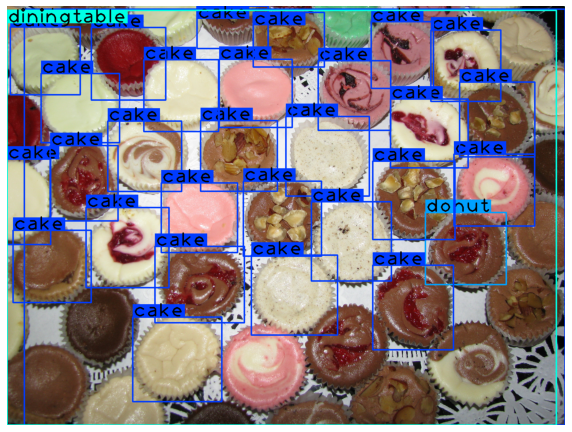

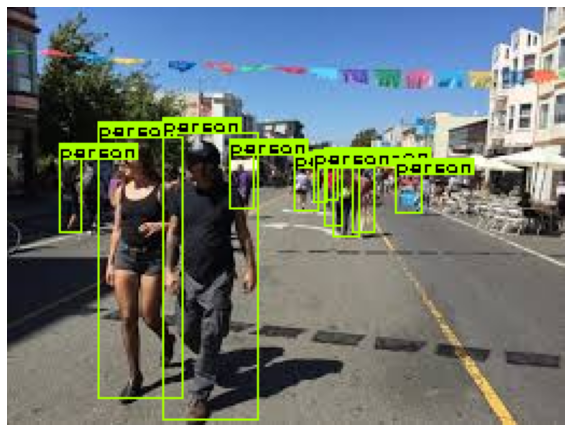

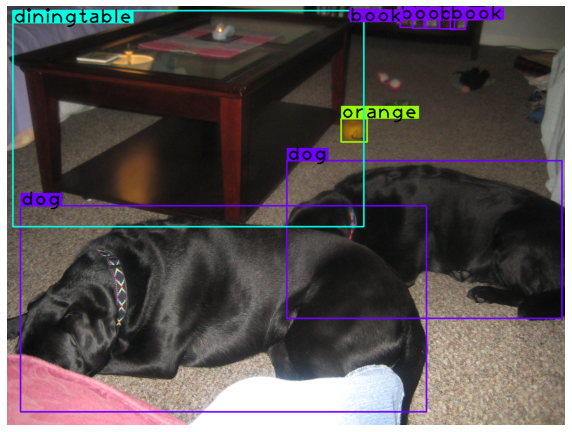

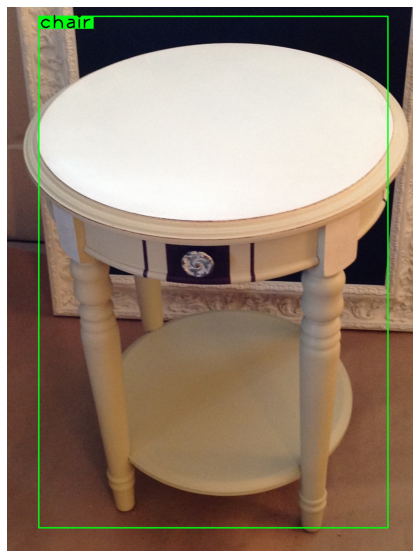

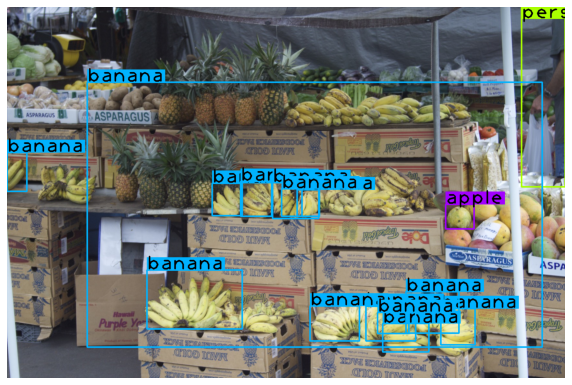

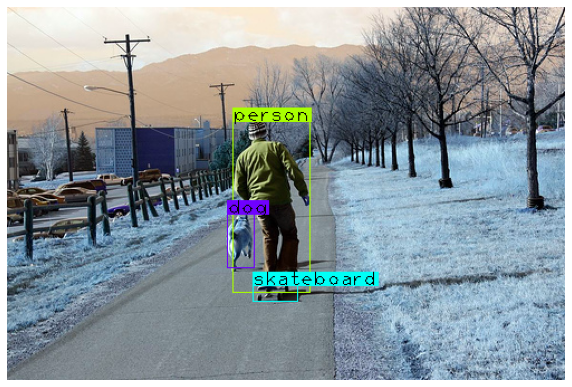

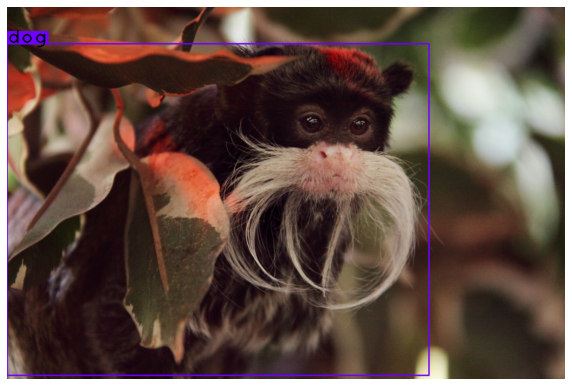

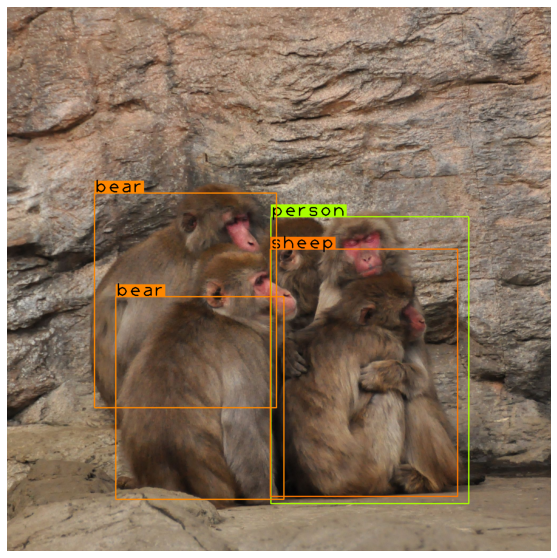

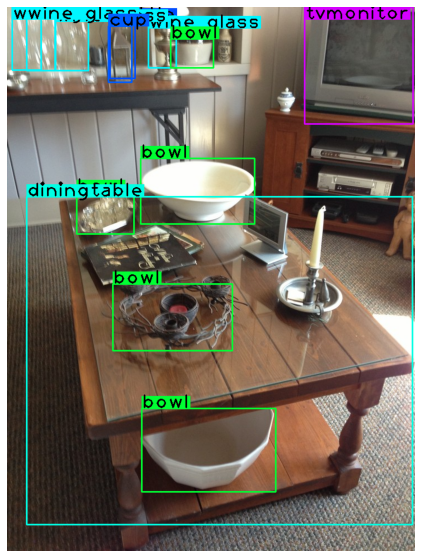

In [11]:
for img_name in os.listdir('test_images/'):
    img_path = os.path.join('test_images', img_name)
    img = read_img(img_path)
    img_aspect = resize_aspect(img, width, height)
    inp = img_to_tensor(img_aspect)
    if CUDA:
        inp = inp.cuda()
    pred = model(inp, CUDA)
    output = write_results(pred, 0.2, num_classes)
    asp = aspect_transform(img.shape[1], img.shape[0], width, height)
    for res in output:
        if res is not None:
            res_original = inv_aspect_transform_results(res, asp)
            res_original = clamp_results(res_original, img.shape[1], img.shape[0])
            img_bbox = draw_predictions(img, res_original, palette, classes)
        else:
            img_bbox = img
        plt.figure(figsize=(10, 10))
        plt.imshow(img_bbox)
        plt.axis('off')
        plt.show()

In [ ]:
cap = cv2.VideoCapture('test_videos/room.mp4')
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output.mp4', fourcc, 60.0, (768,  1328))

counter = 0
if not cap.isOpened():
    print("Cannot open the source")
while cap.isOpened():
    print(f'frame = {counter}')
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_aspect = resize_aspect(img, 608, 608)
    inp = img_to_tensor(img_aspect)
    if CUDA:
        inp = inp.cuda()
    pred = model(inp, CUDA)
    output = write_results(pred, 0.4, 80)
    asp = aspect_transform(img.shape[1], img.shape[0], 608, 608)
    for res in output:
        if res is not None:
            res_original = inv_aspect_transform_results(res, asp)
            res_original = clamp_results(res_original, img.shape[1], img.shape[0])
            img_bbox = draw_predictions(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), res_original, palette, classes)
        else:
            img_bbox = img
        out.write(img_bbox)
    counter += 1
    
    # Display the resulting frame
cap.release()
out.release()
cv2.destroyAllWindows()